# Goal: 

* Download most up-to-date version of NCBI 'complete' genomes

# Setting variables

In [17]:
workDir = '/var/seq_data/ncbi_db/genome/Jan2016/'
proksFile = 'proks_complete.txt'
taxFile = 'proks_complete_tax.txt'

# Init

In [2]:
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(genomes)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: XML

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘XML’


  res = super(Function, self).__call__(*new_args,

In [55]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

%cd $workDir

/var/seq_data/ncbi_db/genome/Jan2016


# Loading list of complete prok genomes

In [19]:
%%R -i workDir -i proksFile 

F = file.path(workDir, proksFile)

df.proks.complete = read.delim(F, sep='\t')

# checking join
df.proks.complete %>% nrow %>% print
df.proks.complete %>% head(n=3)

[1] 4732
     pid                           name          status   released  taxid
1  12997 Acaryochloris marina MBIC11017 Complete Genome 2007-10-16 329726
2  60713 Acetobacterium woodii DSM 1030 Complete Genome 2012-02-14 931626
3 242487       Acetobacter pasteurianus Complete Genome 2015-07-21    438
   bioproject          group              subgroup    size      gc
1  PRJNA12997  Cyanobacteria Oscillatoriophycideae 8.36160 46.9889
2  PRJNA60713     Firmicutes            Clostridia 4.04478 39.3000
3 PRJNA242487 Proteobacteria   Alphaproteobacteria 2.80615 53.3000
         refseq      insdc
1   NC_009925.1 CP000828.1
2   NC_016894.1 CP002987.1
3 NZ_CP012111.1 CP012111.1
                                                                                               plasmid.refseq
1 NC_009930.1,NC_009928.1,NC_009927.1,NC_009931.1,NC_009933.1,NC_009934.1,NC_009932.1,NC_009926.1,NC_009929.1
2                                                                                                  

In [20]:
%%R -i workDir -i taxFile

F = file.path(workDir, taxFile)

df.tax = read.delim(F, sep='\t') %>%
    distinct(taxid)
df.proks.complete = dplyr::inner_join(df.proks.complete, df.tax, c('taxid' = 'taxid'))

# checking join
df.proks.complete %>% nrow %>% print
df.proks.complete %>% nrow %>% print
df.proks.complete %>% head(n=3)

[1] 4732
[1] 4732
     pid                           name          status   released  taxid
1  12997 Acaryochloris marina MBIC11017 Complete Genome 2007-10-16 329726
2  60713 Acetobacterium woodii DSM 1030 Complete Genome 2012-02-14 931626
3 242487       Acetobacter pasteurianus Complete Genome 2015-07-21    438
   bioproject          group              subgroup    size      gc
1  PRJNA12997  Cyanobacteria Oscillatoriophycideae 8.36160 46.9889
2  PRJNA60713     Firmicutes            Clostridia 4.04478 39.3000
3 PRJNA242487 Proteobacteria   Alphaproteobacteria 2.80615 53.3000
         refseq      insdc
1   NC_009925.1 CP000828.1
2   NC_016894.1 CP002987.1
3 NZ_CP012111.1 CP012111.1
                                                                                               plasmid.refseq
1 NC_009930.1,NC_009928.1,NC_009927.1,NC_009931.1,NC_009933.1,NC_009934.1,NC_009932.1,NC_009926.1,NC_009929.1
2                                                                                         

# Just Bacteria

In [21]:
%%R
df.bac.complete = df.proks.complete %>%
    filter(superkingdom == 'Bacteria')

df.bac.complete %>% nrow

[1] 4498


### Phylum representation

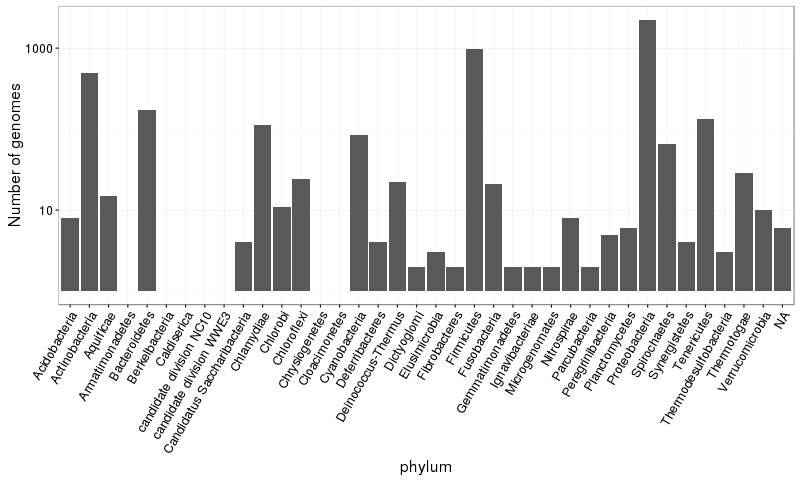

In [22]:
%%R -w 800
df.bac.complete.s = df.bac.complete %>%
    group_by(phylum) %>%
    summarize(n = n()) %>%
    filter(! is.na(n), n > 0)

ggplot(df.bac.complete.s, aes(phylum, n)) +
    geom_bar(stat='identity') +
    scale_y_log10() +
    labs(y = 'Number of genomes') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=60, hjust=1)
    )

### removing what are really phage/plasmid genomes

In [23]:
%%R
cat('Pre-filter:', df.bac.complete %>% nrow, '\n')

to.rm = c("Thermoanaerobacterium saccharolyticum JW/SL-YS485",
          "Streptococcus salivarius 57.I")

df.bac.complete = df.bac.complete %>%
    filter(! name %in% to.rm)

cat('Post-filter:', df.bac.complete %>% nrow, '\n')


Pre-filter: 4498 
Post-filter: 4496 


# Sequence download

In [56]:
%%R -i workDir

outFile = file.path(workDir, 'bac_complete.txt')
write.table(df.bac.complete, outFile, sep='\t', quote=FALSE, row.names=FALSE)

In [ ]:
!seqDB_tools accession-GI2fasta \
    -a 11 -n 2 -f 12 -header -o bac_complete \
    < bac_complete.txt \
    2> bac_complete.log

In [ ]:
%pushnote genome download complete

### Getting list of empty genome files

In [60]:
fileSizes = !ls -tlc *.fna | perl -pe 's/[ \t]+/ /g' 

outFile = 'empty_genome_files.txt'
with open(outFile, 'wb') as outFH:
    for x in fileSizes:
        xx = x.split(' ')
        if xx[4] == '0':
            xx[-1] = xx[-1].replace('_', ' ').rstrip('.fna')
            outFH.write(xx[-1] + '\n')

# status
!printf 'Number of empty genome files: '     
!wc -l $outFile
!head $outFile

Number of empty genome files: 0 empty_genome_files.txt


### Deleting empty files

In [61]:
fileSizes = !ls -tlc bac_complete/*.fna | perl -pe 's/[ \t]+/ /g' 

for x in fileSizes:
    xx = x.split(' ')
    if float(xx[4]) < 100000.0:
        os.remove(xx[-1])

### Checking output

In [62]:
genomeDir = os.path.join(workDir, 'bac_complete')
%cd $genomeDir

/var/seq_data/ncbi_db/genome/Jan2016/bac_complete


In [63]:
# number of genomes downloaded
!printf "Number of bacterial genomes: "
!find . -name "*.fna" | wc -l    

Number of bacterial genomes: 3508


In [64]:
# file size
!echo "Genome file size distribution (bytes):"
!ls -tlc *.fna | \
    perl -pe 's/ +/\t/g' | \
    cut -f 5 | NY_misc_perl stats_descriptive

Genome file size distribution (bytes):
1	min	160314.00
1	Q1	2124608.00
1	mean	3679260.40
1	median	3480661.00
1	Q3	4913670.00
1	max	15028601.00
1	stdev	1949951.34


In [68]:
# checking for non-bacterial genomes
!find . -name "*.fna" | xargs -P 26 -I % bash -c 'egrep "phage|virus|plasmid" %'

In [69]:
# deleting non-bacterial genomes
#!rm -f ./Clostridium_perfringens_SM101.fna \
#    ./Chlamydophila_pneumoniae_AR39.fna \
#    ./Enterococcus_faecalis_62.fna

In [70]:
# number of genomes downloaded
!printf "Number of bacterial genomes: "
!find . -name "*.fna" | wc -l   

Number of bacterial genomes: 3508


# Renaming genomes

In [73]:
genomeDirRn = genomeDir + '_rn'
genomeDirRn

'/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn'

In [74]:
# renameing
!find . -name "*.fna" | \
    SIPSim genome_rename -n 26 --prefix $genomeDirRn - 

File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Chlamydophila_pneumoniae_CWL029.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Helicobacter_cetorum_MIT_99-5656.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Chlamydia_trachomatis_B_TZ1A828_OT.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Streptococcus_anginosus_C238.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Bibersteinia_trehalosi_USDA-ARS-USMARC-190.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Comamonadaceae_bacterium_A1.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Lactobacillus_johnsonii_DPC_6026.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Segniliparus_rotundus_DSM_44985.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_rn/Thermacetogenium_phaeum_DSM_12270.fna
File written: /var/seq_data/ncbi_db/genome/Jan2016/bac_complet